<a href="https://colab.research.google.com/github/saimani5/VAE-tutorials/blob/main/rvae_graphene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   This notebook takes you through the application of rotationally invariant variational autoencoder (rVAE) on STEM image of silicon in graphene manipulated by e-beam activation.  
*   The dataset consists of 50 different STEM images of silicon in graphene.
*   The dataset is initially passed through semantic segmentation DCNN network which classifies each pixel in an image into 3 different classes (C-atom, Si-atom, and background)
*   rVAE comprises of an additional latent dimension to the regular VAE, which explicitly captures the rotations involved in the image.
*   This angular latent dimension is unsupervisedly learned while trying to reconstuct the original image.
*   Like in VAE, this latent dimension is also regularized using a prior.  

The rVAEs are defined and trained using a package called Pyroved (https://github.com/ziatdinovmax/pyroVED) which is built on top of Pyro probabilistic programming framework. Please feel free to write to valletisai.mani@gmail.com for further enquiries.

In [ ]:
# Download the dataset, Will explain what each file corresponds to later
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From: https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
To: /content/3DStack13-1-dec.npy
100% 157M/157M [00:02<00:00, 75.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
100% 52.4M/52.4M [00:00<00:00, 162MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
100% 2.45M/2.45M [00:00<00:00, 245MB/s]


In [ ]:
# Installing Kornia and pyroved
!pip install -q kornia atomai git+https://github.com/ziatdinovmax/pyroVED@main

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 40.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible

In [ ]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt


import pyroved as pv
import kornia as K
from torchvision import datasets

# We will use atomai just to create the dataset (sub-images)
import atomai as aoi
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
tt = torch.tensor

In [ ]:
STEM_real = np.load('3DStack13-1-exp.npy')   # raw STEM Image
decoded_imgs = np.load('3DStack13-1-dec.npy')   # oytput of DCNN where the each pixel is classified as one of the three classes (C, Si, or background)
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]  # The atomic coodinates found by DCNN

Text(0.5, 1.0, 'Atomic coordinates')

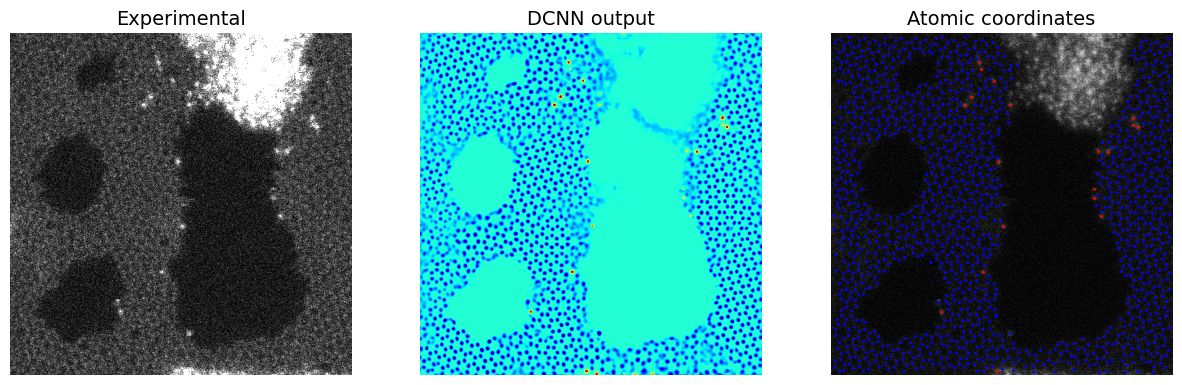

In [ ]:
#Visulaizing one frame of the data, we have 50 frames (0-49)

i = 49 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

In [ ]:
# Getting feature vectors
# Feature vectors here are the cropped images around the coordinates found by DCNN. The window_size of these cropped images can be changed below
window_size = 40   # Window_size
s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord, # Coodinates array, acts as the mid-point of the cropped sub-images
    window_size, 0)

In [ ]:
#Setting the train loader
imstack = tt(s.imgstack[:,None,:,:, 0])
train_loader_graphene = pv.utils.init_dataloader(imstack, batch_size=50)
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

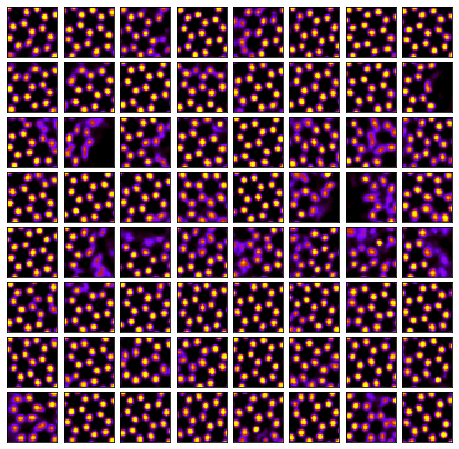

In [ ]:
# Visulaizing the training dataset
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i, 0], cmap='gnuplot', interpolation='nearest')

# plt.savefig('example_imgs.png', dpi = 300)

In [ ]:
# Training the rVAE on the subimages generated 
# The trained weights will be loaded in the next cell
# So, one can skip this cell to save sometime.

in_dim = (40, 40)   # Input dimensions of the dataset i.e., shape of each card's image

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)
rvae_graphene = pv.models.iVAE(in_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                               hidden_dim_e = [512, 512],   # corresponds to the number of neurons in the hidden layers of the encoder
                               hidden_dim_d = [512, 512],   # corresponds to the number of neurons in the hidden layers of the decoder
                               invariances=['r', 't'], seed=0)

# Initialize SVI trainer
trainer_graphene = pv.trainers.SVItrainer(rvae_graphene)
# Train for n epochs:
for e in range(100):
    trainer_graphene.step(train_loader_graphene)
    trainer_graphene.print_statistics()

Epoch: 1 Training loss: 196.5976
Epoch: 2 Training loss: 159.4909
Epoch: 3 Training loss: 157.9948
Epoch: 4 Training loss: 157.2800
Epoch: 5 Training loss: 156.9735
Epoch: 6 Training loss: 156.6114
Epoch: 7 Training loss: 156.2256
Epoch: 8 Training loss: 155.8438
Epoch: 9 Training loss: 155.5069
Epoch: 10 Training loss: 155.2283
Epoch: 11 Training loss: 155.0829
Epoch: 12 Training loss: 154.8497
Epoch: 13 Training loss: 154.6997
Epoch: 14 Training loss: 154.5490
Epoch: 15 Training loss: 154.4528
Epoch: 16 Training loss: 154.3361
Epoch: 17 Training loss: 154.2462
Epoch: 18 Training loss: 154.1924
Epoch: 19 Training loss: 154.1107
Epoch: 20 Training loss: 154.0279
Epoch: 21 Training loss: 153.9852
Epoch: 22 Training loss: 153.8958
Epoch: 23 Training loss: 153.8858
Epoch: 24 Training loss: 153.7813
Epoch: 25 Training loss: 153.7414
Epoch: 26 Training loss: 153.7107
Epoch: 27 Training loss: 153.6349
Epoch: 28 Training loss: 153.5715
Epoch: 29 Training loss: 153.5411
Epoch: 30 Training loss

In [ ]:
# Initializing a new network
in_dim = (40, 40)
rvae_graphene = pv.models.iVAE(in_dim, latent_dim=2,
                               hidden_dim_e = [512, 512],
                               hidden_dim_d = [512, 512],
                               invariances=['r', 't'], seed=0)

# Download the weigths file 
!gdown 1bCuzOM5TJL_zQQS-B_ka1vyCX4FYNDV5

# Loading the saved weights into the newly initialized network
rvae_graphene.load_weights('rvae_graphene.pt')

Downloading...
From: https://drive.google.com/uc?id=1bCuzOM5TJL_zQQS-B_ka1vyCX4FYNDV5
To: /content/rvae_graphene.pt
100% 6.47M/6.47M [00:00<00:00, 333MB/s]


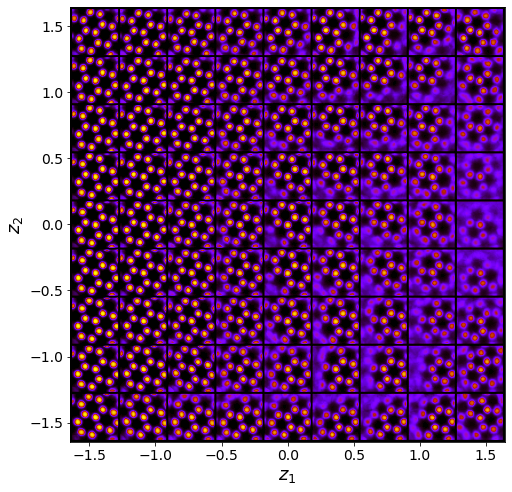

tensor([[[0.2705, 0.1267, 0.0495,  ..., 0.2556, 0.3637, 0.3873],
         [0.1857, 0.0812, 0.0291,  ..., 0.1583, 0.2686, 0.2742],
         [0.1150, 0.0662, 0.0322,  ..., 0.0916, 0.1448, 0.1376],
         ...,
         [0.1304, 0.1369, 0.1469,  ..., 0.0538, 0.0218, 0.0130],
         [0.1340, 0.1494, 0.1883,  ..., 0.1364, 0.0799, 0.0290],
         [0.1176, 0.1379, 0.1728,  ..., 0.2174, 0.1841, 0.1003]],

        [[0.5067, 0.3050, 0.1764,  ..., 0.2509, 0.3516, 0.4148],
         [0.4764, 0.2845, 0.1163,  ..., 0.1662, 0.2729, 0.3392],
         [0.2602, 0.1489, 0.0623,  ..., 0.0986, 0.1858, 0.2111],
         ...,
         [0.2522, 0.2584, 0.2940,  ..., 0.0726, 0.0411, 0.0201],
         [0.2664, 0.2967, 0.3322,  ..., 0.1341, 0.1160, 0.0590],
         [0.2774, 0.3009, 0.3197,  ..., 0.1867, 0.1883, 0.1444]],

        [[0.4334, 0.3075, 0.2423,  ..., 0.2563, 0.3153, 0.3275],
         [0.3857, 0.2925, 0.1759,  ..., 0.1930, 0.2238, 0.2554],
         [0.2101, 0.1461, 0.0793,  ..., 0.1296, 0.1711, 0.

In [ ]:
# Visualizing decoded latent space
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions

rvae_graphene.manifold2d(d = 9)   # d corresponds to the number of points sampled in each latent dimension

In [ ]:
z_mean, z_sd = rvae_graphene.encode(imstack)   # Encoding the full input dataset
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

# z_mean1: mean of the latent space representation of the input dataset, 
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column (z1): corresponds to angle and 
# 1st columsn (z2): Corresponds to the translations
# (z3) then the regular latent dimensions 

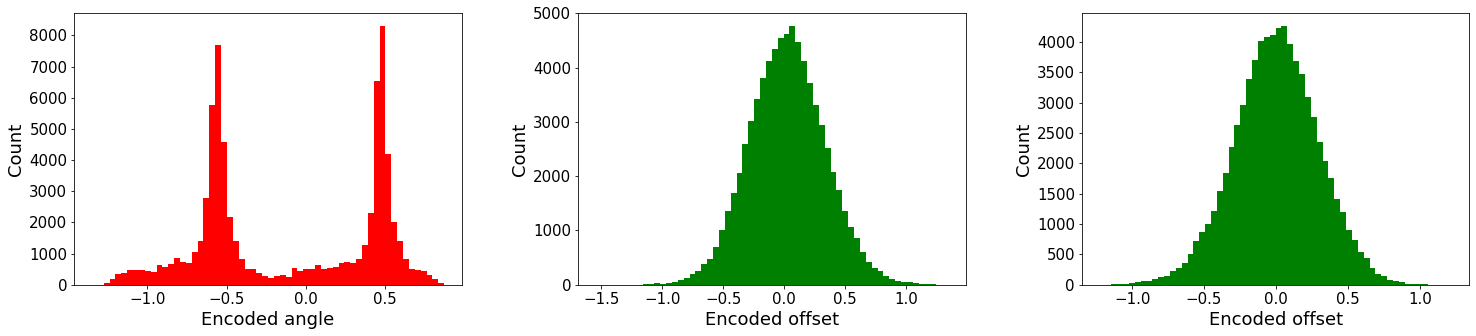

In [ ]:
# Histograms of the encoded angle and the translations

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='red')
ax[1].hist(z2[:, 0], bins=60, color='green')
ax[2].hist(z2[:, 1], bins=60, color='green')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
ax[2].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

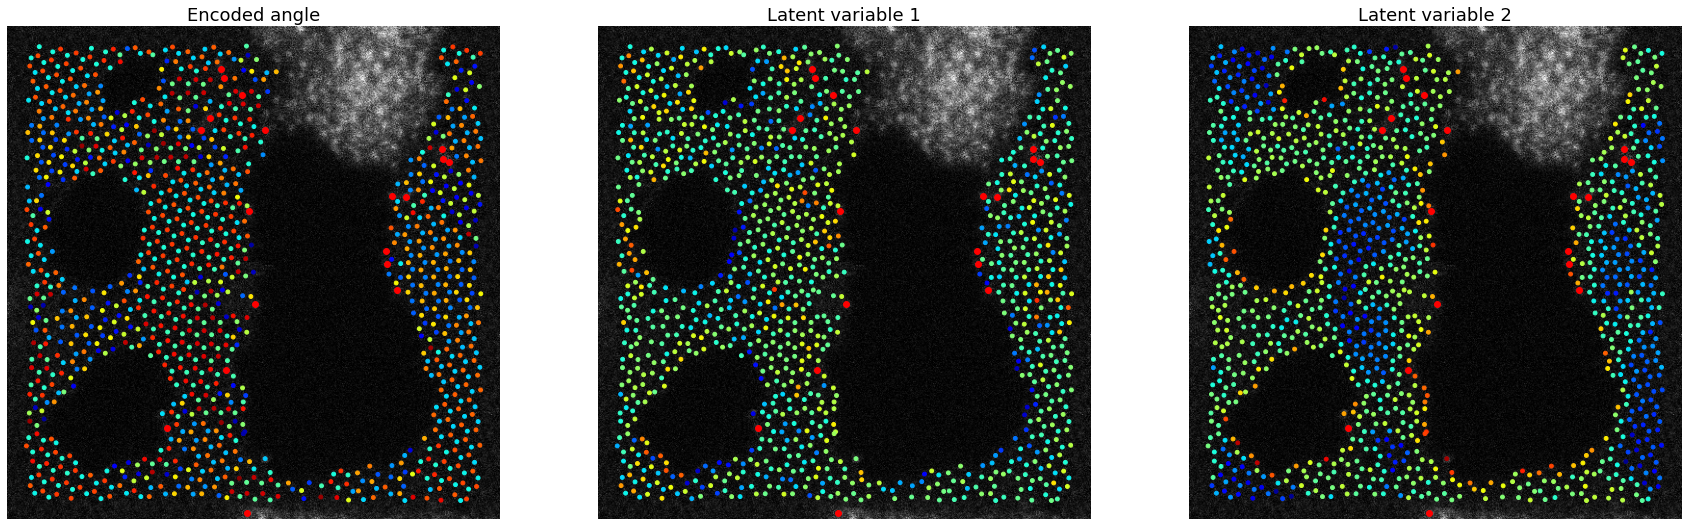

In [ ]:
#Visualizing the latent space encodings on the raw STEM image

frame = 49 # select frame

com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].imshow(STEM_real[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet", vmin=col_min0, vmax=col_max0)
ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(STEM_real[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(STEM_real[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()